# Lab 7.06 - Time series analysis

In [3]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe

import scipy.stats as stats                         # Statistical tests
from sklearn.linear_model import LinearRegression   # Linear regression model

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

## Exercise 6: COVID-19 data


In this lab assignment, we will make use of the COVID-19 dataset maintained by [Our World in Data](https://ourworldindata.org/coronavirus), published on Github at <https://github.com/owid/covid-19-data/tree/master/public/data>.

We took a snapshot of the data on 2023-05-31 that still contains *daily* observations. Recently, the dataset has been updated to only contain weekly observations.

First, we import the dataset, parse the `date` column as the Python `DateTime` type and set this as the index.

**Tip:** The CSV file is rather large, so instead you may want to load a local copy of the CSV file to avoid downloading it multiple times ('../data/owid-covid-data-2023-05-31.csv').

In [4]:
covid19 = pd.read_csv(
    'https://github.com/HoGentTIN/dsai-labs/raw/main/data/owid-covid-data-2023-05-31.csv',
    parse_dates=['date'],
    index_col=['date'])
covid19.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-04,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-05,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-06,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-07,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


Create a new `DataFrame` (with name e.g. `covid19_be`) that only contains the new cases in Belgium and use the `plot()` method of `DataFrame` to visualize it. Increase the size of the picture with the `figsize` parameter, otherwise it will be too small.

In [5]:
covid19_be = covid19[covid19.iso_code == 'BEL'][['new_cases']]
covid19_be.head()

,new_cases
date,
2020-01-03,0.0
2020-01-04,0.0
2020-01-05,0.0
2020-01-06,0.0
2020-01-07,0.0


### Moving average

Add new columns to the data frame with new cases in Belgium with the simple moving average for 7 and 30 days. Plot the entire data frame (observations and both moving averages).

<Axes: xlabel='date'>

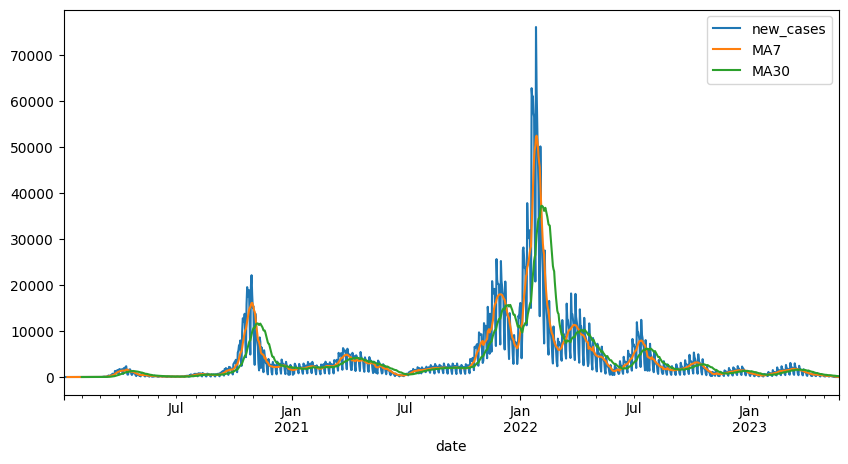

In [6]:
covid19_be['MA7'] = covid19_be['new_cases'].rolling(7).mean()
covid19_be['MA30'] = covid19_be['new_cases'].rolling(30).mean()
covid19_be.plot(y=['new_cases', 'MA7',	'MA30'], figsize=[10,5])

### Holt-Winters model for new cases early 2021

The period from about December 2020 up to the end of February 2021 seems quite regular. Create a new `DataFrame` and select only the observations during that period (1 December 2020 to 28 February 2021). Plot the `DataFrame` (it will still contain the moving averages from the previous step).

<Axes: xlabel='date'>

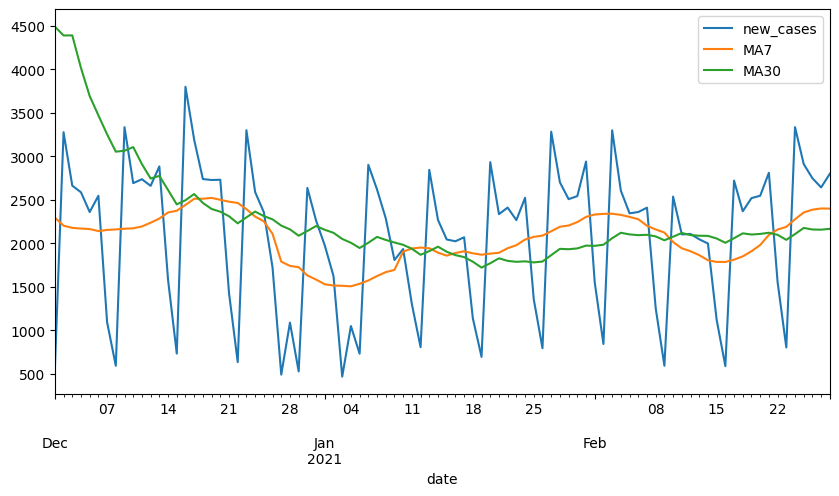

In [7]:
cvd = covid19_be['2020-12-01':'2021-02-28']
cvd.plot(y=['new_cases', 'MA7',	'MA30'], figsize=[10,5])



Build a Holt-Winters model for the observed new cases during that period.

Use the additive type for both trend and seasonal smoothing. Set the value for `seasonal_periods` to the appropriate value! Plot the observed and fitted values.

<Axes: xlabel='date'>

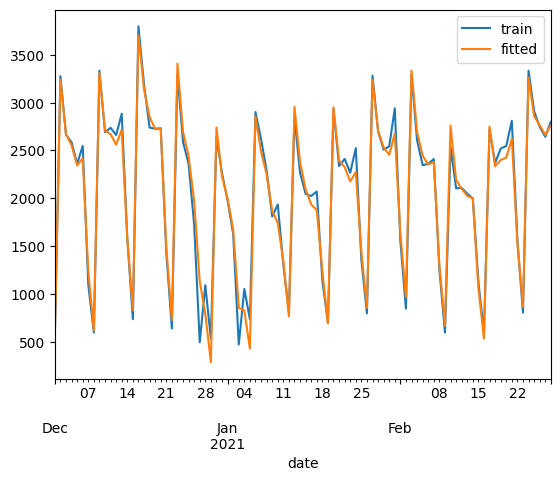

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = cvd['new_cases']

cvd_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7, freq='D').fit()

train.plot(legend=True, label='train')
(cvd_hw.level + cvd_hw.season).plot(legend=True, label='fitted')

Now, make a forecast for 21 days and plot observed and forecasted values. What do you notice when you compare observed and forecasted values as time progresses?

<Axes: xlabel='date'>

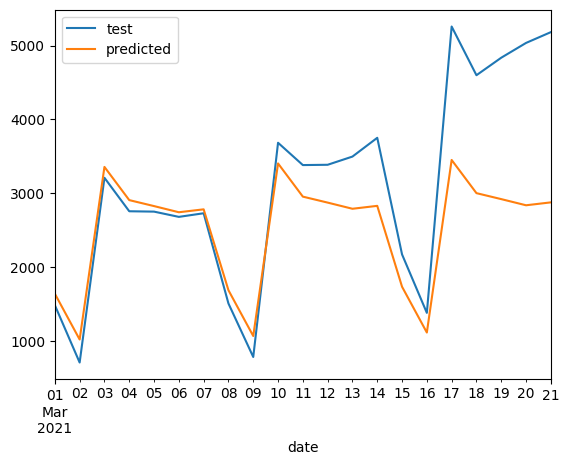

In [9]:
cvd_predicted = cvd_hw.forecast(21)
test = covid19_be['2021-03-01':'2021-03-21']

test['new_cases'].plot(legend=True, label='test')
cvd_predicted.plot(legend=True, label='predicted')

### Evaluating model quality


- Calculate the Mean Squared Error for a forecast period of 7 days, and compare its square root with the standard deviation of observed new cases over the test period and forecasted period combined.
- Do the same for a forecast period of 14 and 21 days.
- For which period is the quality of the forecast ok?

The expected results are shown in the table below:

|     Forecast period      |         MSE |     √MSE |    stdev |
| :----------------------: | ----------: | -------: | -------: |
| 2021-03-01 to 2021-03-07 |   25408.902 |  159.402 |  855.684 |
| 2021-03-01 to 2021-03-14 |  154280.817 |  392.786 |  895.531 |
| 2021-03-01 to 2021-03-21 | 1048835.781 | 1024.127 | 1052.978 |

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

for x, y in zip((7, 14, 21), ('2021-03-07','2021-03-14','2021-03-21')):
  cvd_predicted = cvd_hw.forecast(x)
  test = covid19_be['2021-03-01':y]
  print(f'√MSE {x}  = {np.sqrt(mean_squared_error(test["new_cases"],cvd_predicted))}')
  print(f'stdev {x} = {test["new_cases"].std()}')

√MSE 7  = 159.40169889360502
stdev 7 = 890.1978645757571
√MSE 14  = 392.78596852637935
stdev 14 = 1047.863939242512
√MSE 21  = 1024.1268381527102
stdev 21 = 1407.8773603921477


### ICU patients

Create a new `DataFrame` with only the total number of ICU (intensive care units) patients in the Belgian hospitals. Make sure that all NaN's are removed, since time series analysis functions can't cope with missing values. Plot this time series.

In [16]:
covid19 = pd.read_csv(
    'https://github.com/HoGentTIN/dsai-labs/raw/main/data/owid-covid-data-2023-05-31.csv',
    parse_dates=['date'], usecols=['date', 'iso_code', 'icu_patients']
).set_index(['date'])

In [17]:
covid19 = covid19[covid19.iso_code == 'BEL']
covid19 = covid19[['icu_patients']]
covid19 = covid19.dropna()
covid19.head()

,icu_patients
date,
2020-03-15,53.0
2020-03-16,79.0
2020-03-17,100.0
2020-03-18,130.0
2020-03-19,164.0


<Axes: xlabel='date'>

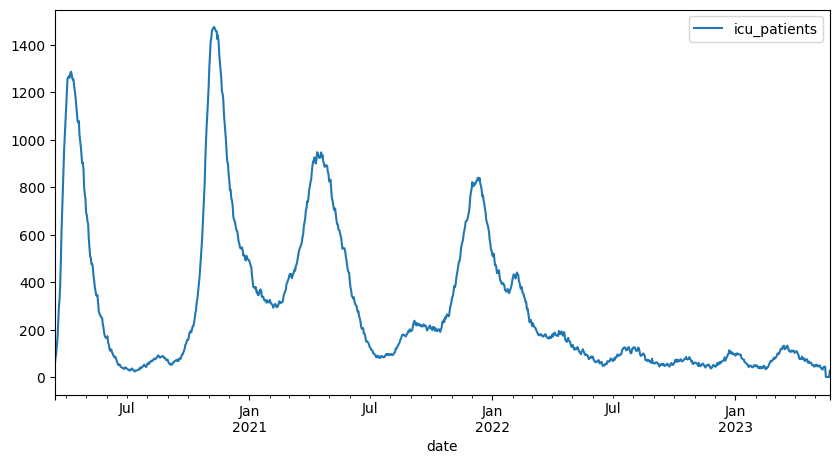

In [18]:
covid19.plot(y=['icu_patients'], figsize=[10,5])

Build a duible exponential smoothing (Holt) model of this time series. Make a forecast of 70 time units and plot the observations, fitted values and forecast.

Are we currently in an upward or downward trend, according to this model? Do the forecasted values seem reasonable if you look at the last period?

In [19]:
from statsmodels.tsa.api import Holt

data_des = Holt(covid19['icu_patients']).fit()

covid19['fittedvalues'] = data_des.fittedvalues
covid19.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,icu_patients,fittedvalues
date,,
2020-03-15,53.0,79.000000
2020-03-16,79.0,70.784089
2020-03-17,100.0,98.300413
2020-03-18,130.0,120.178714
2020-03-19,164.0,153.352797


<Axes: xlabel='date'>

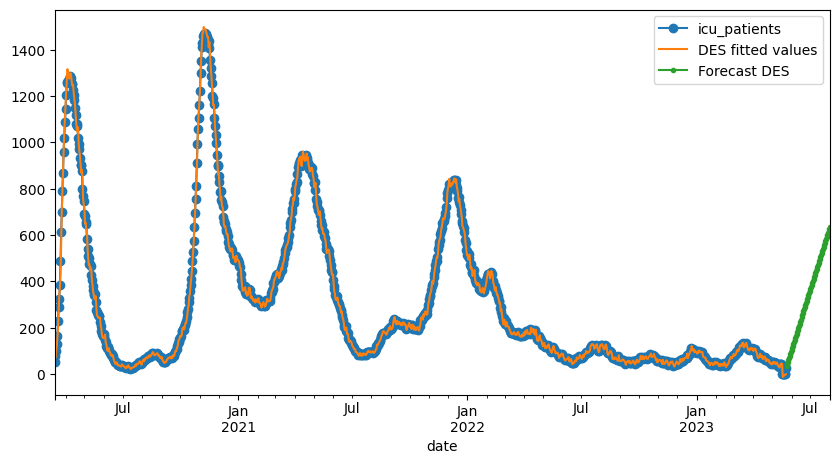

In [20]:
data_des_fcast = data_des.forecast(70)

covid19['icu_patients'].plot(marker='o', legend=True) # Observations
covid19['fittedvalues'].plot(legend=True, label='DES fitted values', figsize=[10,5])
data_des_fcast.plot(marker='.', legend=True, label='Forecast DES')

Since we didn't set any initial parameters like $\alpha$ and $\beta$, the model calculated them using some rule of thumb. List these parameters from the model:

In [21]:
data_des.params_formatted

,name,param,optimized
smoothing_level,alpha,0.958466,True
smoothing_trend,beta,0.373023,True
initial_level,l.0,53.000000,False
initial_trend,b.0,26.000000,False


What were the final estimated values for the level and trend, that are used in the forecast? In other words, what are the parameters of the line that estimates future observations?

In [22]:
data_des.trend

date
2020-03-15    16.704213
2020-03-16    19.641650
2020-03-17    20.249304
2020-03-18    23.760711
2020-03-19    27.567409
                ...    
2023-05-19    -6.366694
2023-05-20    -3.930723
2023-05-21    -2.424196
2023-05-22    -1.494901
2023-05-23     8.731486
Length: 1165, dtype: float64

Let's try to set the parameters ourselves. Recreate the Holt-model with $\alpha = \beta = 0.1$. Calculate a forecast like before and plot.

Compare the model parameters and final estimates. Which of the two forecast models seems to perform best if you look at the plots?